In this worksheet we will demonstrate learning sentiment extraction from text.

The dataset is the IDMB sentiment set where items were annotated by taggers as to if the text appeared to be expressing a positive or negative sentiment. This data set was produced by and used in:

> Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

The data can be found here: [https://ai.stanford.edu/~amaas/data/sentiment/](https://ai.stanford.edu/~amaas/data/sentiment/).

In our example we will use the GloVe embedding as our language model and Keras as our neural net software. The neural net architecture we are specifying is essentially a logistic regression over an average meaning of neighboring triplets of words in a document. The idea is: positive sentiment documents are often mostly positive utterances, and negative sentiment documents are often mostly negative utterances. We hope the non-sentiment carrying portions are largely ignored by the model.

In [1]:
# ensure plots print without needing to call show()
%matplotlib inline

In [2]:
# import our packages
import pandas
import numpy
import sys

import wvpy.util

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline

In [3]:
# set up Keras imports, this can be brittle
# no longer import keras, import tensorflow.keras
import tensorflow.keras as keras
# https://github.com/keras-team/keras/issues/12379#issuecomment-473823330
from tensorflow.keras import *
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
from tensorflow.keras.layers import *
#from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
#from keras.models import Model
#from keras.optimizers import RMSprop
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop
from tensorflow.keras.optimizers import *

In [4]:
# training hyper-parameters
# often searching, on simulated out of sample data,
# for good values of these can impove model quality.
epochs = 200
batch_size = 512
validation_split = 0.2
explicit_mix_controls = False
assumed_confidence = 0.9
black_box_model = False
simple_model = False

In [5]:
# get our data and language model through data adaptors
sys.path.append('.')
# put data load on our path
sys.path.append('../data/IMDB')
from load_IMDB import load_IMDB
sys.path.append('../data/GloVe')
from document_encoder import GloveEncoder

In [6]:
# load the IMDB data
train_data, test_data = load_IMDB()

In [7]:
# show how many training examples
len(train_data.data)

25000

In [8]:
# show how many test examples
len(test_data.data)


25000

In [9]:
# load the glove vectors we need, uses about 4GB of memory
glove_path = '../data/GloVe/glove.840B.300d.zip'
k = 3  # how many neighboring words to model
encoder = GloveEncoder(
    glove_path=glove_path,
    k=k,
)

In [10]:
# train the encoder on what words it is to recognize
encoder.fit(X=train_data.data)

In [11]:
# build our neural net factory
# this one implements a logistic regression.

# get our data shape from using the encoder
# so we don't have the brittleness of hard-coding.
encode_dim = encoder.encode_text("this is an example text", k=k).shape[0]

def mk_model(
    *, 
    simple_model: bool = False,
    explicit_mix_controls: bool = False,
    black_box_model: bool = False):
    """
    This is an augmented logistic model.
    It predicts a 2-vector [p_class, p_class_augmented] or a 4-vector [p_class, p_class_augmented, certainty, uncertainty].
    The augmentation is, smoothing to 0.5 by the degree of ambiguousness
    """
    input_layer = Input(shape=(encode_dim, ), name='inputs')
    # model0: basic logistic regression
    model0_logistic_layer = Dense(1, name='model0_logistic_layer', activation='sigmoid')(input_layer)
    if simple_model:
        result_layer = model0_logistic_layer
    else:
        # mix: sensor fusion style selection between model0 and 0.5
        half_value = Dense(1, name='half_value')(model0_logistic_layer)  # set weights to: multiply by zero and add 0.5 to get 0.5
        signals_layer = Concatenate(name='signals_layer')([model0_logistic_layer, half_value])
        mix_link_layer = Dense(2, name='mix_link_layer')(input_layer)
        mix_logistic_layer = Softmax(name='mix_logistic_layer')(mix_link_layer)
        mix_combined = Multiply(name='mix_combined')([signals_layer, mix_logistic_layer])
        mix_sum = Dense(1, name='mix_sum')(mix_combined)  # will set weights non-trainable to get effect we want
        if black_box_model:
            result_layer = mix_sum
        else:
            if explicit_mix_controls:
                result_layer = Concatenate(name='result_layer')([model0_logistic_layer, mix_sum, mix_logistic_layer])
            else:
                result_layer = Concatenate(name='result_layer')([model0_logistic_layer, mix_sum])
        # https://keras.io/api/models/model/
        logistic_model = Model(input_layer, result_layer)
        # make max sum add with weight 1 and no bias
        mix_model_layer = logistic_model.get_layer('mix_sum')
        mix_model_layer.set_weights([numpy.array([[1.0], [1.0]]), numpy.array([0.0])])
        mix_model_layer.trainable = False
        # form constant 0.5 as alternate model
        half_value = logistic_model.get_layer('half_value')
        half_value.set_weights([numpy.array([[0.0]]), numpy.array([0.5])])
        half_value.trainable = False
    logistic_model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy')
    return logistic_model

logistic_model = mk_model(
    simple_model=simple_model,
    explicit_mix_controls=explicit_mix_controls,
    black_box_model=black_box_model)
logistic_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 900)]        0                                            
__________________________________________________________________________________________________
model0_logistic_layer (Dense)   (None, 1)            901         inputs[0][0]                     
__________________________________________________________________________________________________
half_value (Dense)              (None, 1)            2           model0_logistic_layer[0][0]      
__________________________________________________________________________________________________
mix_link_layer (Dense)          (None, 2)            1802        inputs[0][0]                     
______________________________________________________________________________________________

2022-03-09 15:15:43.400338: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# shuffle rows of training data in case neural net batching takes in ordered chunks
permutation = numpy.random.choice(len(train_data.data), size=len(train_data.data), replace=False)
train_data_shuffled = [train_data.data[i] for i in permutation]
train_target_shuffled = [train_data.target[i] for i in permutation]


In [13]:
def aug_output(v):
    """Augment training target"""
    if black_box_model or simple_model:
        return [v]
    if explicit_mix_controls:
        return [v, v, assumed_confidence, 1.0 - assumed_confidence]
    return [v, v]

In [14]:
%%capture
# do the training on our first model, all the data
history_big = logistic_model.fit(
    encoder.transform(train_data_shuffled),
    numpy.asarray([aug_output(v) for v in train_target_shuffled]),
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split)

2022-03-09 15:16:21.660941: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [15]:
trajectory = pandas.DataFrame(history_big.history)
trajectory['epoch'] = range(trajectory.shape[0])

trajectory_plot = trajectory.melt(
    id_vars=['epoch'],
    value_vars=['loss', 'val_loss'],
    var_name='data set',
    value_name='estimated loss',
)

Text(0.5, 1.0, 'model loss as a function of epoch\n(smaller better)')

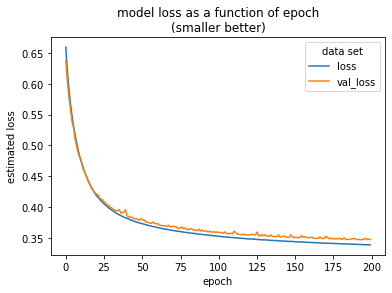

In [16]:
sns.lineplot(
    data=trajectory_plot,
    x='epoch',
    y='estimated loss',
    hue = 'data set',
)
plt.title("model loss as a function of epoch\n(smaller better)")

In [17]:
# wrap the text processing plus model
# as a single object implementing the model API
model = make_pipeline(encoder, logistic_model)

In [18]:
# get predictions on data not seen during training!
pred_test = model.predict(test_data.data)

In [19]:
pred_test


array([[0.01352978, 0.02222092],
       [0.09707555, 0.10741898],
       [0.03993312, 0.06154231],
       ...,
       [0.52848357, 0.5252829 ],
       [0.39057812, 0.39078665],
       [0.4974137 , 0.4974862 ]], dtype=float32)

In [20]:
pred_test_frame = pandas.DataFrame(pred_test).copy()
if pred_test_frame.shape[1] == 1:
    # just block box prediction
    pred_test_frame.columns = ['prediction']
    pred_test_frame['prediction_augmented'] = pred_test_frame['prediction']
    pred_test_frame['confidence'] = 1.0
elif pred_test_frame.shape[1] == 2:
    # just prediction and augmented prediction
    pred_test_frame.columns = ['prediction', 'prediction_augmented']
    pred_test_frame['confidence'] = (pred_test_frame['prediction_augmented'] - 0.5) / (pred_test_frame['prediction'] - 0.5)
elif pred_test_frame.shape[1] == 4:
    # prediction, augmented prediction, and mixing coefficients
    pred_test_frame.columns = ['prediction', 'prediction_augmented', 'confidence', 'uncertainty']
    del pred_test_frame['uncertainty']
else:
    raise ValueError(f'not expected pred_test_frame.shape[1] == {pred_test_frame.shape[1]}')

pred_test_frame['truth'] = numpy.array(test_data.target, dtype=float)

In [21]:
pred_test_frame

,prediction,prediction_augmented,confidence,truth
0,0.013530,0.022221,0.982134,0.0
1,0.097076,0.107419,0.974329,0.0
2,0.039933,0.061542,0.953030,0.0
3,0.162766,0.207117,0.868484,0.0
4,0.734129,0.731479,0.988681,0.0
...,...,...,...,...
24995,0.485289,0.485417,0.991277,1.0
24996,0.109404,0.206450,0.751543,1.0
24997,0.528484,0.525283,0.887632,1.0
24998,0.390578,0.390787,0.998094,1.0


In [22]:
pred_test_frame.describe()

,prediction,prediction_augmented,confidence,truth
count,2.500000e+04,25000.000000,25000.000000,25000.00000
mean,4.817623e-01,0.483454,0.980142,0.50000
std,3.670958e-01,0.360479,0.049269,0.50001
min,4.212375e-11,0.000029,0.018868,0.00000
25%,1.014876e-01,0.112104,0.982310,0.00000
50%,4.619908e-01,0.463690,0.993103,0.50000
75%,8.656594e-01,0.857539,0.997368,1.00000
max,1.000000e+00,0.999986,0.999997,1.00000


Our hope is, that this more complicated model uses the confidence estimate to identify unreliable instances and to maybe even improve predictions. The effect is weak, a basic logistic regression gets a test deviance of 0.712 (lower is better)- and this could probably be acheived by mere regularization. But we do see identification of lower quality predictions and a slight improvement. The next step is data augmentation, where we combine positive and negative examples to build deliberately ambiguous training instances. (Note: ambiguous data augmentation could be tried on the original logistic regression also!) We also have the issue of having slowed down training (so number of epochs may not be comparable) and having introduced new hyperparameters.

In [23]:
uncertain = pred_test_frame['confidence'] < numpy.quantile(pred_test_frame['confidence'], q= 1 - assumed_confidence)
pred_test_frame.loc[uncertain, :]

,prediction,prediction_augmented,confidence,truth
2,0.039933,0.061542,0.953030,0.0
3,0.162766,0.207117,0.868484,0.0
5,0.072951,0.101886,0.932245,0.0
8,0.021956,0.065274,0.909384,0.0
20,0.144481,0.160033,0.956255,0.0
...,...,...,...,...
24991,0.226029,0.255358,0.892949,1.0
24992,0.831942,0.815080,0.949201,1.0
24993,0.198104,0.277967,0.735462,1.0
24996,0.109404,0.206450,0.751543,1.0


In [24]:
if numpy.sum(uncertain) > 0:
    dev = wvpy.util.mean_deviance(
        predictions=pred_test_frame.loc[uncertain, 'prediction'],
        istrue=pred_test_frame.loc[uncertain, 'truth']
    )
    print(dev)

0.8786435784164791


In [25]:
if numpy.sum(uncertain) > 0:
    dev = wvpy.util.mean_deviance(
        predictions=pred_test_frame.loc[uncertain, 'prediction_augmented'],
        istrue=pred_test_frame.loc[uncertain, 'truth']
    )
    print(dev)

0.8578742276996374


As we said, overall this model does not significantly out-perform our basic logistic regression example (02_IMDB_sentiment/IMDB_sentiment.ipynb) which has a deviance of 0.712 (lower is better)

In [26]:
wvpy.util.mean_deviance(
    predictions=pred_test_frame['prediction'],
    istrue=pred_test_frame['truth']
)

0.7086432473079336

In [27]:
wvpy.util.mean_deviance(
    predictions=pred_test_frame['prediction_augmented'],
    istrue=pred_test_frame['truth']
)

0.7057186359506841

<Figure size 432x288 with 0 Axes>

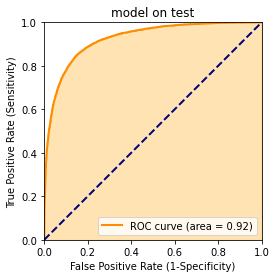

0.9239789472

In [28]:
# evaluate the results
wvpy.util.plot_roc(
    pred_test_frame['prediction'],
    pred_test_frame['truth'],
    title='model on test')


<Figure size 432x288 with 0 Axes>

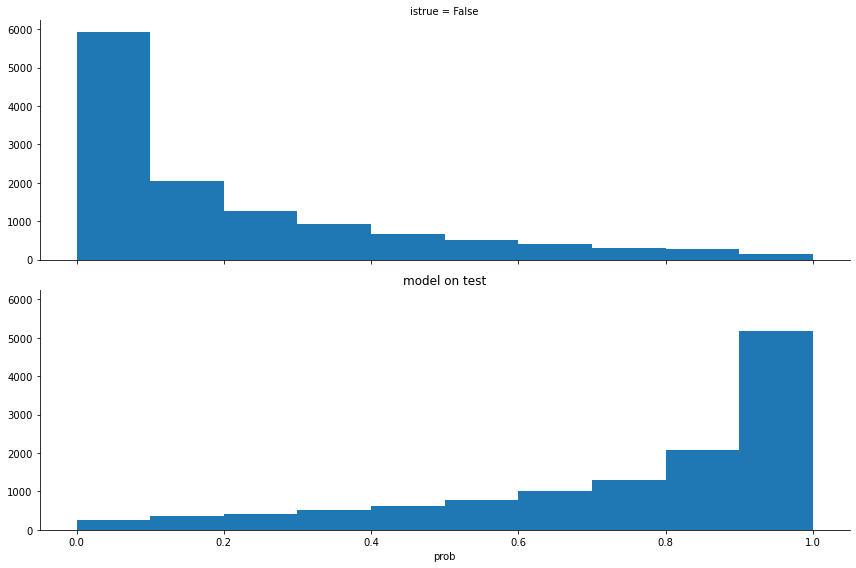

In [29]:
# evaluate the results
wvpy.util.dual_hist_plot(
    pred_test_frame['prediction'],
    pred_test_frame['truth'],
    truth_target=1,
    title='model on test')


In [30]:
pandas.crosstab(
    pred_test_frame['truth'] > 0.5,
    pred_test_frame['prediction'] > 0.5)



prediction,False,True
truth,,
False,10843,1657
True,2151,10349


<Figure size 432x288 with 0 Axes>

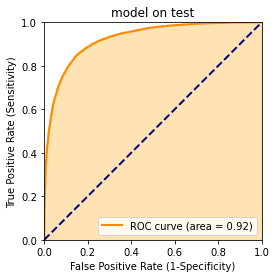

0.9244293024

In [31]:
# evaluate the results
wvpy.util.plot_roc(
    pred_test_frame['prediction_augmented'],
    pred_test_frame['truth'],
    title='model on test')

<Figure size 432x288 with 0 Axes>

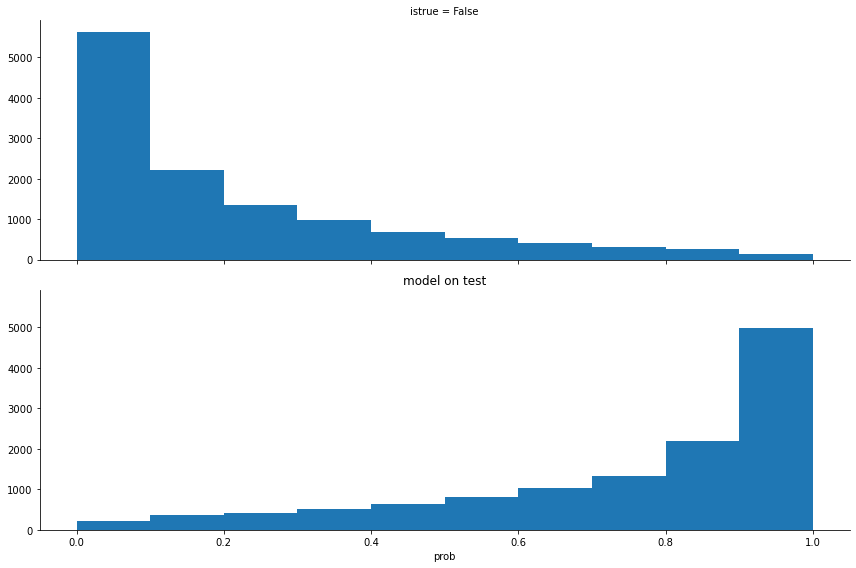

In [32]:
# evaluate the results
wvpy.util.dual_hist_plot(
    pred_test_frame['prediction_augmented'],
    pred_test_frame['truth'],
    truth_target=1,
    title='model on test')

Copyright &copy; 2019-2022 Win-Vector LLC.  All rights reserved. [http://www.win-vector.com](http://www.win-vector.com)